# Keras CNN for Patch Classification with Satellite Data 

### Preparing data  
Data sets is "EuroSAT"; 10 land cover categories from industrial to permanent crop, 27k 64x64 pixel chips, 3/16 band Sentinel-2 satellite imagery (10m res.), covering cities in 30 countries.  
Downloading and unzip "EuroSAT (RGB color space images)" datasets from http://madm.dfki.de/downloads to *~/datasets* directory.

This notebook is inspired by https://github.com/rdcolema/tensorflow-image-classification/blob/master/cnn.ipynb.

In [1]:
import time
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from subprocess import check_output
from datetime import timedelta
from tqdm import tqdm

### Check filenames and data size

In [2]:
data_dir = "../datasets/EuroSAT_RGB/"
cl_nms = os.listdir(data_dir)

# Eliminate hidden file's name
cl_nms = [cl_nms[i] for i in range(len(cl_nms)) if (cl_nms[i][0])!='.']
n_files = []
for c in range(len(cl_nms)):
    volume = len(os.listdir(os.path.join(data_dir, cl_nms[c])))
    n_files.append(volume)
pd_nclass = pd.DataFrame(n_files, index=cl_nms)
pd_nclass = pd_nclass.rename(columns={0 : "# of samples"})
pd_nclass

,# of samples
Highway,2500
PermanentCrop,2500
River,2500
Forest,3000
HerbaceousVegetation,3000
Industrial,2500
AnnualCrop,3000
SeaLake,3000
Pasture,2000
Residential,3000


### Load image data and convert jpeg format to numpy array
Data format of downloaded image data is "jpeg". Therefore, they should be changed to numpy arrary for inputting tensorflow network.

In [3]:
dir_sets = "../datasets/EuroSAT_RGB/"
images = []
labels = []
for dn in range(len(cl_nms)):
    cl_nm = cl_nms[dn]
    file_nm_list = os.listdir(os.path.join(dir_sets, cl_nm))
    for fn in tqdm(range(len(file_nm_list))):
        im = cv2.imread(os.path.join(os.path.join(dir_sets, cl_nm), file_nm_list[fn]))
        images.append(im)
        labels.append(cl_nm)
images = np.array(images)
labels = np.array(labels)
print(images.shape, labels.shape)

100%|██████████| 3000/3000 [00:00<00:00, 3893.18it/s]


(27000, 64, 64, 3) (27000,)


### Check some patches in RGB on display

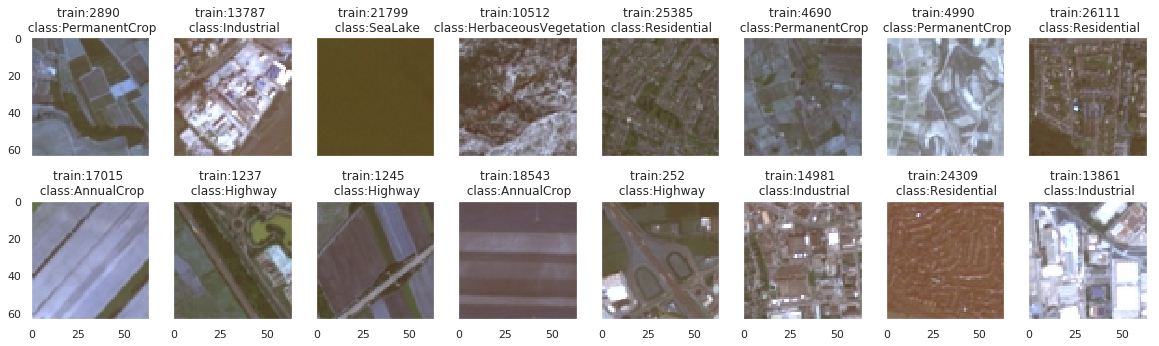

In [4]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(2, 8, sharex='col', sharey='row', figsize=(20, 5.5), facecolor='w')
i = 0
for i in range(16):
    j = np.random.randint(labels.shape[0])
    ax[i // 8, i % 8].imshow(images[j])
    ax[i // 8, i % 8].set_title('train:%d \n class:%s' %(j, labels[j]))
plt.show()

### Apply one-hot encoding to label data

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

le = preprocessing.LabelEncoder()
print('labels:', cl_nms)
le.fit(cl_nms)
print('number: ', le.transform(cl_nms))

labels_enc = le.transform(labels).reshape(-1,1)
labels_oh = OneHotEncoder(categories='auto').fit_transform(labels_enc).A
print('Dimensionality of one-hot encoded label file:', labels_oh.shape)

labels: ['Highway', 'PermanentCrop', 'River', 'Forest', 'HerbaceousVegetation', 'Industrial', 'AnnualCrop', 'SeaLake', 'Pasture', 'Residential']
number:  [3 6 8 1 2 4 0 9 5 7]
Dimensionality of one-hot encoded label file: (27000, 10)


### Split to training and test data from downloaded data
In this case, spliting rate is 0.05 ( training data : test data = 19 : 1 )

In [6]:
from sklearn.model_selection import train_test_split

splitting_rate = 0.05
random_state = 1
x_train, x_test, y_train, y_test = train_test_split(
        images, labels_oh, test_size=splitting_rate, stratify=labels_oh, random_state=random_state)

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(x_train.shape[0]))
print("- Validation-set:\t\t{}".format(x_test.shape[0]))
print("Dim of:")
print("- Training-set:\t\t{}".format(x_train.shape[1:]))
print("- Test-set:\t\t{}".format(x_test.shape[1:]))

Size of:
- Training-set:		25650
- Validation-set:		1350
Dim of:
- Training-set:		(64, 64, 3)
- Test-set:		(64, 64, 3)


### Normalization  
Functions for normalizing value of training data and test data between 0 to 1

In [8]:
IMAGE_NORMALIZATION = True
# normalization
def image_normalize_std(x_train, x_test):
    x_mean = np.mean(x_train, axis=0)
    x_std = np.std(x_train, axis=0)
    return np.divide((x_train - x_mean), x_std), np.divide((x_test - x_mean), x_std)

if IMAGE_NORMALIZATION:
    x_train, x_test = image_normalize_std(x_train, x_test)

### Split training data to training and validation data

In [9]:
from sklearn.model_selection import train_test_split
splitting_rate = 0.01
random_state = 1
x_train_tr, x_train_val, y_train_tr, y_train_val = train_test_split(
        x_train, y_train, test_size=splitting_rate, stratify=y_train, random_state=random_state)

In [10]:
print("Size of:")
print("- Training-set:\t\t{}".format(x_train_tr.shape[0]))
print("- Validation-set:\t\t{}".format(x_train_val.shape[0]))
print("Dim of:")
print("- Training-set:\t\t{}".format(x_train_tr.shape[1:4]))
print("- Validation-set:\t\t{}".format(x_train_val.shape[1:]))

Size of:
- Training-set:		25393
- Validation-set:		257
Dim of:
- Training-set:		(64, 64, 3)
- Validation-set:		(64, 64, 3)


## Keras##

### Set paramters
Decide 'epochs', batch size and early stooping

In [11]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense
from keras.models import Model
import keras.callbacks
from keras import applications

#reset the default graph to empty
tf.reset_default_graph()

# Epoch
EPOCHS = 15

# Dropout
DROPOUT = 0.5

# flag for early stopping
early_stopping = None

# Batch size
BATCH_SIZE_TR = 256
n_batches_tr = x_train_tr.shape[0] // BATCH_SIZE_TR
BATCH_SIZE_VAL = x_train_val.shape[0]
n_batches_val = x_train_val.shape[0] // BATCH_SIZE_VAL
BATCH_SIZE_TS = x_test.shape[0]
n_batches_ts = x_train_val.shape[0] // BATCH_SIZE_TS

Using TensorFlow backend.


### Building Layers
In this case, two layers CNN is defined as a simple CNN model.

In [13]:
img_input = Input(shape=x_train.shape[1:])
classes = y_train.shape[1]

# Block 1
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
x = Dropout(DROPOUT, name='block1_dropout')(x)

# Block 2
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
x = Dropout(DROPOUT, name='block2_dropout')(x)

# Block 2
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
x = Dropout(DROPOUT, name='block3_dropout')(x)

# Classification block
x = Flatten(name='flatten')(x)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dropout(DROPOUT, name='dropout')(x)
x = Dense(classes, activation='softmax', name='predictions')(x)
model = Model(img_input, x, name='cnn')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 16)        448       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 32)        4640      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 32)        0         
_________________________________________________________________
block1_dropout (Dropout)     (None, 32, 32, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 64)        18496     
__________

### Cost-function, Optimization, and evaluation-fuction
Softmax cross entropy is applied to this case due to multi-class classification  
Adam is applied as optimization method.
Evaluation fuctions are loss (default) and accuracy (added by "metrics")

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Tensorboard
Set save directory and output topics

In [15]:
LOG_DIR = 'tmp/tensorboard/keras_CNN'
if not os.path.isdir(LOG_DIR):
    os.makedirs(LOG_DIR)
tbcallback = TensorBoard(log_dir=LOG_DIR, histogram_freq=1, write_graph=True, write_grads=True)

### Run
Execute optimization in "epoch" times.

In [16]:
history = model.fit(x_train_tr, y_train_tr, batch_size=BATCH_SIZE_TR, epochs=EPOCHS, verbose=1, 
          validation_data=(x_train_val, y_train_val), callbacks=[tbcallback])

Train on 25393 samples, validate on 257 samples
Epoch 1/15
25393/25393 [==============================] - 12s 489us/step - loss: 1.7571 - acc: 0.2973 - val_loss: 1.3298 - val_acc: 0.4942
Epoch 2/15
25393/25393 [==============================] - 7s 293us/step - loss: 1.1115 - acc: 0.5836 - val_loss: 0.8370 - val_acc: 0.7237
Epoch 3/15
25393/25393 [==============================] - 7s 295us/step - loss: 0.7818 - acc: 0.7311 - val_loss: 0.7089 - val_acc: 0.7471
Epoch 4/15
25393/25393 [==============================] - 7s 294us/step - loss: 0.6593 - acc: 0.7736 - val_loss: 0.9511 - val_acc: 0.6615
Epoch 5/15
25393/25393 [==============================] - 7s 292us/step - loss: 0.6109 - acc: 0.7929 - val_loss: 0.6896 - val_acc: 0.7354
Epoch 6/15
25393/25393 [==============================] - 7s 286us/step - loss: 0.5406 - acc: 0.8154 - val_loss: 0.5672 - val_acc: 0.7860
Epoch 7/15
25393/25393 [==============================] - 8s 296us/step - loss: 0.4761 - acc: 0.8402 - val_loss: 0.4256 - v

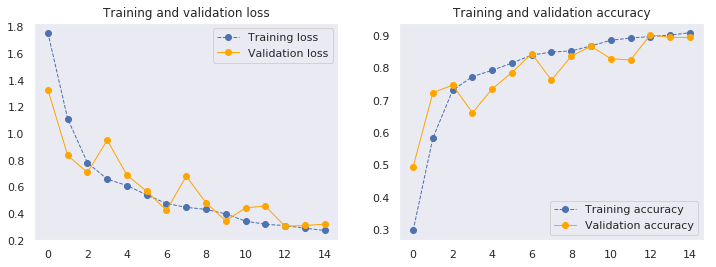

In [17]:
# Plot training and validation loss
acc = history.history['acc']
acc_val = history.history['val_acc']
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(len(acc))

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12,4))

axL.plot(epochs, loss, linestyle='dashed', linewidth = 1.0, marker='o', label='Training loss')
axL.plot(epochs, loss_val, color='orange',  linestyle='solid', linewidth = 1.0, marker='o', label='Validation loss')
axL.set_title('Training and validation loss')
axL.legend()
# plt.savefig(save_path_p1)
axR.plot(epochs, acc, linestyle='dashed', linewidth = 1.0, marker='o', label='Training accuracy')
axR.plot(epochs, acc_val, color='orange',  linestyle='solid', linewidth = 1.0, marker='o', label='Validation accuracy')
axR.set_title('Training and validation accuracy')
axR.legend()

In [18]:
pred_test = model.predict(x_test, verbose=1)
pred_test_le = np.argmax(pred_test, axis=1)
y_test_le = np.argmax(y_test, axis=1)

1350/1350 [==============================] - 1s 551us/step


In [19]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_le, pred_test_le)
print(conf_matrix)

# Create a boolean array whether each image is correctly classified.
correct = (y_test_le == pred_test_le)

# Calculate the number of correctly classified images.
# When summing a boolean array, False means 0 and True means 1.
correct_sum = correct.sum()
acc = float(correct_sum) /len(pred_test_le)
# Print the accuracy.
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, correct_sum, len(pred_test_le)))

[[120   4  10   1   0   9   5   0   1   0]
 [  0 149   0   0   0   1   0   0   0   0]
 [  0   4 143   1   0   0   0   2   0   0]
 [  2   0   5 106   1   5   1   3   2   0]
 [  0   0   2   1  97   0   0  25   0   0]
 [  0   9   6   0   0  82   0   0   3   0]
 [  0   0  60   1   1   1  59   2   1   0]
 [  0   0   0   0   0   0   0 150   0   0]
 [  2   1   4  11   0   9   0   0  97   1]
 [  0   2   0   0   0   0   0   0   1 147]]
Accuracy on Test-Set: 85.2% (1150 / 1350)
